## CIFAR-10 

Introduced by Krizhevsky et al. in [Learning multiple layers of features from tiny images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)

The CIFAR-10 dataset (Canadian Institute for Advanced Research, 10 classes) is a subset of the Tiny Images dataset and consists of 60000 32x32 color images. The images are labelled with one of 10 mutually exclusive classes: airplane, automobile (but not truck or pickup truck), bird, cat, deer, dog, frog, horse, ship, and truck (but not pickup truck). There are 6000 images per class with 5000 training and 1000 testing images per class.

![image](../../images/cifar10.png)

Source: https://www.cs.toronto.edu/~kriz/cifar.html

In [134]:
import os 
import re
import numpy as np
import wget
import tarfile
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

import torch
import torchvision

from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import Tuple, Dict, List, Any

In [135]:
# versions
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

# device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# cuda version
print(f"Cuda version: {torch.version.cuda}")

# created date
print(f"Created date: 2023-08-17 13:27:46")

# modified date
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Modified date: {now}")

Torch version: 1.12.1+cu102
Torchvision version: 0.13.1+cu102
Device: cuda
Cuda version: 10.2
Created date: 2023-08-17 13:27:46
Modified date: 2023-08-17 14:57:45


In [136]:
DATA_DIR = Path('../../data/')
if not DATA_DIR.is_dir():
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    
DATASET_URL = "https://pjreddie.com/media/files/cifar.tgz"

DATASET_ZIPFILE_NAME = "cifar.tgz"
DATASET_FOLDER_NAME = "cifar"

In [137]:
DATASET_ZIPFILE_PATH = DATA_DIR.joinpath(DATASET_ZIPFILE_NAME)
DATASET_FOLDER_PATH = DATA_DIR.joinpath(DATASET_FOLDER_NAME)

In [138]:
# download the dataset 
if DATASET_ZIPFILE_PATH.is_file():
    print(f"The {DATASET_ZIPFILE_NAME} already exists. Skipped downloading.")
else:
    print(f"The {DATASET_ZIPFILE_NAME} is downloading...")
    try:
        wget.download(url=DATASET_URL, out=str(DATA_DIR))
    except Exception as error:
        print(f"Caught this error {error}")
    print(f"The {DATASET_ZIPFILE_NAME} is downloaded succesfully.") 

The cifar.tgz already exists. Skipped downloading.


In [139]:
# extract the dataset 
if DATASET_FOLDER_PATH.is_dir():
    print(f"The {DATASET_ZIPFILE_NAME} is already extracted. Skipped extracting.")
else: 
    print(f"The {DATASET_ZIPFILE_NAME} is extracting...") 
    try:
        tarfiler = tarfile.open(DATASET_ZIPFILE_PATH)
        tarfiler.extractall(path=DATA_DIR)
        tarfiler.close()
    except Exception as error:
        print(f"Caught this error: {error}")
    
    print(f"The {DATASET_ZIPFILE_NAME} is extracted succesfully.") 

The cifar.tgz is already extracted. Skipped extracting.


In [140]:
# train directory
train_dir = DATASET_FOLDER_PATH.joinpath("train")
if train_dir.is_dir():
    for filepaths, dirnames, filenames in os.walk(train_dir):
        if len(filenames) > 0:
            print(f"[TRAINING SET] - There are {len(filenames)} images in the {filepaths}")
else:
    print(f"Please make sure the {train_dir} exists")
    
# test directory 
test_dir = DATASET_FOLDER_PATH.joinpath("test")
if test_dir.is_dir():
    for filepaths, dirnames, filenames in os.walk(test_dir):
        if len(filenames) > 0:
            print(f"[TESTING SET] - There are {len(filenames)} images in the {filepaths}")
else:
    print(f"Please make sure the {test_dir} exists")

[TRAINING SET] - There are 50000 images in the ../../data/cifar/train
[TESTING SET] - There are 10000 images in the ../../data/cifar/test


In [141]:
# file paths of training set
training_file_paths = [entry.path for entry in os.scandir(train_dir)]
print(f"len: {len(training_file_paths)}")
training_file_paths

len: 50000


['../../data/cifar/train/40659_horse.png',
 '../../data/cifar/train/4909_automobile.png',
 '../../data/cifar/train/40527_bird.png',
 '../../data/cifar/train/34157_frog.png',
 '../../data/cifar/train/25736_truck.png',
 '../../data/cifar/train/12997_deer.png',
 '../../data/cifar/train/35871_bird.png',
 '../../data/cifar/train/44095_deer.png',
 '../../data/cifar/train/34299_dog.png',
 '../../data/cifar/train/21382_deer.png',
 '../../data/cifar/train/22522_automobile.png',
 '../../data/cifar/train/47673_horse.png',
 '../../data/cifar/train/20433_horse.png',
 '../../data/cifar/train/9283_cat.png',
 '../../data/cifar/train/45051_dog.png',
 '../../data/cifar/train/23089_truck.png',
 '../../data/cifar/train/3734_automobile.png',
 '../../data/cifar/train/7240_truck.png',
 '../../data/cifar/train/16832_ship.png',
 '../../data/cifar/train/23491_airplane.png',
 '../../data/cifar/train/27017_deer.png',
 '../../data/cifar/train/6802_bird.png',
 '../../data/cifar/train/32592_airplane.png',
 '../../da

In [142]:
# file paths of testing set
test_file_paths = [entry.path for entry in os.scandir(test_dir)]
print(f"len: {len(test_file_paths)}")

file_path  = test_file_paths[0]
print(file_path)

pattern = "_(.*?).png"
class_name = re.search(pattern, file_path).groups()[0]
print(class_name)


len: 10000
../../data/cifar/test/1364_deer.png
deer


In [143]:
class CIFAR10ImageFolder(Dataset):
    def __init__(self, root: str, transform: None) -> None:
        super().__init__()

        self.file_paths = [entry.path for entry in os.scandir(root)]
        self.transform = transform
        self.classes, self.class_to_idx = self.find_class(directory=root)

    def find_class(self, directory: str):

        classes = []
        if Path(directory).is_dir():
            file_paths = [entry.path for entry in os.scandir(directory)]
            for file_path in file_paths:
                pattern = "_(.*?).png"
                class_name = re.search(pattern, file_path).groups()[0]
                if class_name not in classes:
                    classes.append(class_name)

            classes = sorted(classes)
        else:
            raise FileNotFoundError(f"Couldn't find the directory {directory}")
        
        class_to_idx = None
        if classes:
            
            class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}
        else: 
            raise ValueError("There isn't any class name in classes")

        return classes, class_to_idx
    
    def load_image(self, file_path: str) -> Image.Image:

        if Path(file_path).is_file():
            return Image.open(file_path)
        else:
            raise FileNotFoundError(f"Coundn't find the image file in the given path {file_path}")
        
    def __len__(self) -> int:
        return len(self.file_paths)
    
    def __getitem__(self, index) -> Tuple[Any, int]:
        
        file_path = self.file_paths[index]

        # get image
        image = self.load_image(file_path)
        if self.transform:
            image = self.transform(image)


        # get class names
        pattern = "_(.*?).png"
        class_name = re.search(pattern, file_path).groups()[0]
        class_idx = self.class_to_idx[class_name]

        return image, class_idx

In [144]:
# transform helper
transform_helper = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [145]:
# train_data
train_data = CIFAR10ImageFolder(root=train_dir, transform=transform_helper)

train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [146]:
train_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [147]:
# class names
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [148]:
# test_data
test_data = CIFAR10ImageFolder(root=test_dir, transform=transform_helper)
test_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [149]:
test_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [150]:
# dataloader
train_dataloader = DataLoader(dataset=train_data, batch_size=10, num_workers=0, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=10, num_workers=0, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f9743fd78e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9743fd79a0>)

Text(0.5, 1.0, 'automobile')

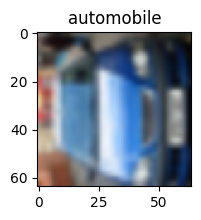

In [176]:
# random samples
random_sample = torch.utils.data.RandomSampler(test_data, num_samples = 10)
random_sample_dataloader = DataLoader(test_data, batch_size=1, sampler=random_sample)

# one batch
img_custom, label_custom = next(iter(random_sample_dataloader))

# display img_custom
plt.figure(figsize=(2,2))
plt.imshow(img_custom.squeeze().permute(2,1,0))
plt.title(f"{class_names[label_custom]}")

#### References

1. https://paperswithcode.com/dataset/cifar-10